# HW 11 Transfer learning for your dataset on a chosen pretrained model
------
USE: https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
## Для выполнения задания необходимо выполнить ряд импортов, включая предопределенные "magic functions"


In [1]:
%matplotlib inline

In [2]:
import time
import os
import copy

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from typing import Dict, List, Text, Optional, Tuple


### **Определяем базовую директорию и указывем относительные пути к тренировочному и тестовому набору данных**

In [3]:
BASE_DIR = os.path.dirname(os.path.abspath('__file__'))
path_train = 'img_dataset/train'
path_test = 'img_dataset/test'

Для обучения модели необходимо подготовить набор данных и при необходимости увеличить набор данных с применением аугментации.
В данной ДЗ для этого был применен скрипт отдельным файлом, для большего удобства, копия кода и скрипт прилагаются:
```python
import os
import copy

import numpy as np
from PIL import Image
from imgaug import augmenters as iaa


BASE_DIR = os.path.dirname(os.path.abspath(__file__))

resize_w = 320
resize_h = 320

# folder names
# jaguar, lion, panther
folder_name = 'jaguar_train'
path_folder = f'{BASE_DIR}/{folder_name}'
path_folder_resize = f'{BASE_DIR}/{resize_w}_{resize_h}_{folder_name}'
os_listdir = os.listdir(path_folder)

# Выполнение аугментации данных True/False
augmentation = True

img_aug = []
# применение аугментации (поворот и шум)
seq = iaa.Sequential([
    iaa.Affine(rotate=(-25, 25)),
    iaa.AdditiveGaussianNoise(scale=(10, 45)),
])

for filename in os_listdir:
    if filename[filename.rfind(".") + 1:] in ['jpg', 'jpeg', 'png']:
        print(f'обрабатываем {filename}')
        # Чтение файла и конвертирование изображения из 4 каналов в 3 канала
        raw_img = Image.open(f'{path_folder}/{filename}').convert('RGB')
        resize_image = raw_img.resize((resize_w, resize_h))
        if not os.path.exists(path_folder_resize):
            os.makedirs(path_folder_resize, exist_ok=True)
        if augmentation:
            img_np = np.asarray(resize_image)
            img_aug = [copy.copy(img_np) for el in range(2)]
            img_aug = seq(images=img_aug)
            img_aug = [Image.fromarray(np.uint8(el)) for el in img_aug]
            for el in img_aug:
                el.save(f'{path_folder_resize}/{resize_w}_{resize_h}_{img_aug.index(el)}_{filename}')
        resize_image.save(f'{path_folder_resize}/{resize_w}_{resize_h}_{filename}')
    else:
        print(f'{filename} не обрабатывается')
```


К подготовленным тренировочному и тестовому наборам данных описываем трансформации: изменение размера, соответствующее примененной предтенированной модели ResNet18 224х224, конвертирование в тензор и применение нормализации.

In [5]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Формируем наборы данных с применением транформаций.
Выводим на экран случайные образцы из тренировочного набора данных для визуальной оценки качества.

In [6]:
train_dataset = torchvision.datasets.ImageFolder(
    root=f'{BASE_DIR}/{path_train}',
    transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(
    root=f'{BASE_DIR}/{path_test}',
    transform=test_transform)

2100


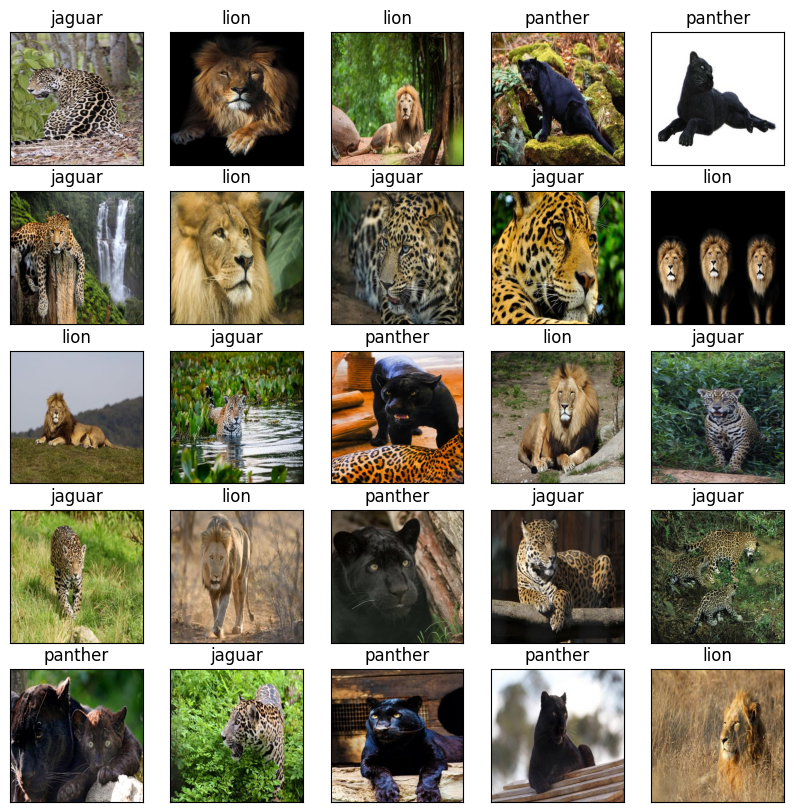

In [7]:
fig = plt.figure(figsize=(10, 10))
rows, columns = 5, 5
visualize_dataset = torchvision.datasets.ImageFolder(root=f'{BASE_DIR}/{path_train}')
# rand_indeces = np.random.randint(low=0, high=len(visualize_dataset), size=(rows*columns,))
rand_indeces = np.random.randint(low=0, high=len(train_dataset), size=(rows*columns,))
images = []
labels = []

for i in rand_indeces:
    img, class_ = visualize_dataset[i]
    images.append(img)
    labels.append(visualize_dataset.classes[class_])

# visualize these random images
for i in range(1, columns * rows + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title(f"{labels[i-1]}")

Импортируем веса модели ResNet18
Указываем размер батча, число эпох.
Заменяем последний слой предтренированной модели на необходимый для последующего обучения, с указанием требуемого количества нейронов, соответствующих требуемого количества классов. "Замораживаем" обучение всех слоев, кроме выходного слоя.

In [8]:
from torchvision.models import ResNet18_Weights

# Number of classes in the dataset
num_classes = len(train_dataset.classes)

# Batch size for training (change depending on how much memory you have)
batch_size = 250

# Number of epochs to train for
num_epochs = 12

# Device for running training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Training only the last layer, the other layers are freezed
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
print(f"{num_ftrs = }")

num_ftrs = 512


In [9]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    train_acc_history = []
    train_loss_history = []

    val_acc_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    y_pred_proba = torch.softmax(outputs, dim=1)
                    y_pred = y_pred_proba.argmax(dim=1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(y_pred == labels)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            torch.save(model, f"e{epoch}_course_model_p{phase}_l{epoch_loss:.4f}_a{epoch_acc:.4f}.pth")

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history, train_acc_history, train_loss_history

In [10]:
# Create training and validation datasets

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Create training and validation dataloaders
dataloaders_dict = {
    "train": train_dataloader,
    "val": test_dataloader,
}

In [11]:
# Send the model to GPU
model = model.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params=model.parameters())

In [12]:
from torchsummary import summary
print(summary(model, input_size=(3, 224, 224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

----
По результатам проведения нескольких экспериментов было принято число эпох равное 12 для наглядности графика показателя accuracy и показателя loss.

## **В результате эксперимента видно, что transfer learning на предтренированной модели ResNet18 для набора данных из 1000 образцов для каждого из трех классов проходи довольно быстро, уже на первых эпохах показатель точности превысил 93% и тремился к максимуму с кадой последующей эпохой, что наглядно видно на графиках показателя accuracy и loss. Исходя из этого можно сделать вывод что нейроны предтренированной модели ResNet18 хорошо обучены на наборе данных из 1000 классов и обучение выходного слоя для трех классов с небольшим набором данных из 3000 образцов не составляет сложности и обучение стремиться к оверфиту** ##

In [12]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, val_acc_history, val_loss_history, train_acc_history, train_loss_history = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/11
----------
train Loss: 0.9223 Acc: 0.6029
val Loss: 0.5165 Acc: 0.9333

Epoch 1/11
----------
train Loss: 0.4555 Acc: 0.9310
val Loss: 0.2626 Acc: 0.9756

Epoch 2/11
----------
train Loss: 0.2639 Acc: 0.9671
val Loss: 0.1496 Acc: 0.9933

Epoch 3/11
----------
train Loss: 0.1821 Acc: 0.9800
val Loss: 0.1122 Acc: 0.9911

Epoch 4/11
----------
train Loss: 0.1423 Acc: 0.9800
val Loss: 0.0859 Acc: 0.9922

Epoch 5/11
----------
train Loss: 0.1160 Acc: 0.9848
val Loss: 0.0701 Acc: 0.9956

Epoch 6/11
----------
train Loss: 0.0981 Acc: 0.9895
val Loss: 0.0641 Acc: 0.9956

Epoch 7/11
----------
train Loss: 0.0891 Acc: 0.9895
val Loss: 0.0563 Acc: 0.9956

Epoch 8/11
----------
train Loss: 0.0739 Acc: 0.9929
val Loss: 0.0522 Acc: 0.9967

Epoch 9/11
----------
train Loss: 0.0711 Acc: 0.9919
val Loss: 0.0461 Acc: 0.9967

Epoch 10/11
----------
train Loss: 0.0643 Acc: 0.9929
val Loss: 0.0435 Acc: 0.9967

Epoch 11/11
----------
train Loss: 0.0621 Acc: 0.9924
val Loss: 0.0415 Acc: 0.9967

Tr

In [13]:
val_acc_history_cpu = [i.item() for i in val_acc_history]
val_loss_history_cpu = val_loss_history
train_acc_history_cpu = [i.item() for i in train_acc_history]
train_loss_history_cpu = train_loss_history

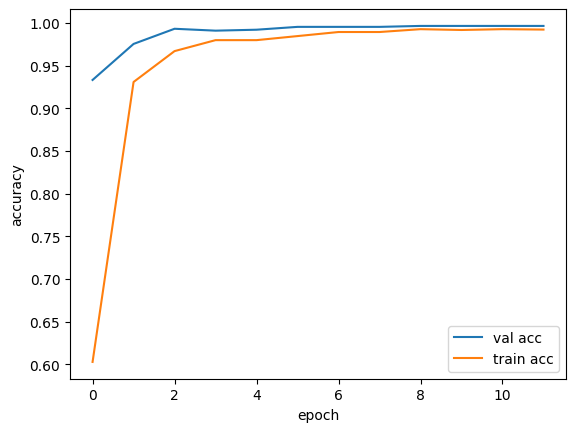

In [14]:
plt.plot(val_acc_history_cpu, label="val acc")
plt.plot(train_acc_history_cpu, label="train acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

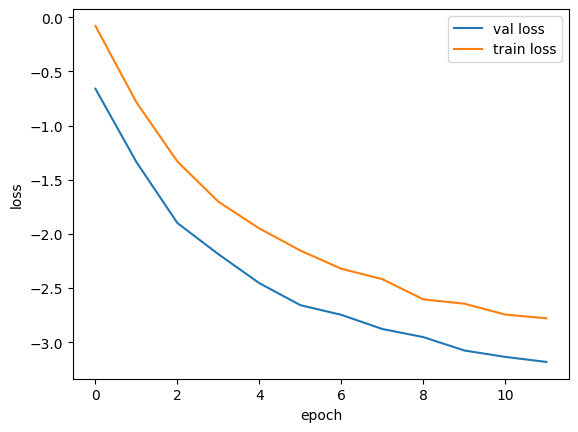

In [15]:
plt.plot(np.log(np.array(val_loss_history_cpu)), label="val loss")
plt.plot(np.log(np.array(train_loss_history_cpu)), label="train loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()